In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt

In [2]:
class state(object):    
    """The state class which is used to construct a state object which in this instance represents a 
    position in the grid defined by its x and y co-ordinates.
    The class contains information such
    self.x: (int)The x co-ordinate of the state on the grid
    self.y: (int)The y co-ordinate of the state on the grid
    self.loc: (tuple) the actual position of the state on the grid (x,y)
    self.reward: (float) Reward associated with the state
    self.isReachable: (boolean) True if the state is reachable. Unreachable states are blocked by obstacles
    self.isTerminalState: (boolean) True if the the goal location or the fire location
    self.isStartLocation: (boolean) True if at the initial position
    self.freeLocs: (tuple) representing positions not to be blocked such as right and down from the starting
    point to allow initial movement 
    
    
    """
    def __init__(self, x,y, reward = -1, isReachable = True, isTerminalState= False):
        self.x = x
        self.y = y
        self.loc = (x,y)
        self.reward = reward
        self.isReachable = isReachable 
        self.isTerminalState = isTerminalState
        self.isStartLocation = self.isStartLoc()
        self.freeLocs = [(0,1), (1,0)]
    
    def blockable(self): #Return true if blockable. Terminal and freeLocs are not blockable
        return self.playable() and not self.loc in self.freeLocs  
    
    def playable(self): #playable states are Reachable non terminal states
        return self.isReachable and not self.isTerminalState
    
    def isStartLoc(self): #Return true if at the starting location
        if self.loc == (0,0):
            return True
        return False

    def setReward(self, reward): #To set reward associated with each state
        self.reward = reward
        
    def isAccessible(self): #Return true if the state is reachable
        return self.isreachable
    
    def block(self): #Add a block to a particular state
        self.isReachable = False
    def getReward(self): #Return reward for state
        return self.reward
    
    def setAsTerminal(self): #Set a particular state as terminal 
        self.isTerminalState = True
    def isTerminal(self): #Return True if state is terminal
        return self.isTerminalState

#state(1,1, -1, True, False).blockable()
    

True

In [3]:
"""Design and return the grid world
                parameters:
                xDim: (int)Height of the gridworld 
                yDIm: (int)width of the grid world
                numBlocks: (int) number of arbitrarily set blocks in the grid
                reward: (float) reward for all normal states in the block. Initially set for all states
                speacial states can then be modified with state.setReward(reward)
"""
def designGridWorld(xDim, yDim, numBlocks = 3, reward = -1): #Design the grid world given its length and width
    """Create an ndArray of state objects of size [xDim, yDim]
    """ 
    gridWorld = np.array([[state(i,j,reward) for j in range(yDim)] for i in range(xDim)], dtype = object)
    print("Grid world created")
    gridWorld[-1,0].setAsTerminal() #set The grid at the bottom left as terminal
    print("Goal Location set as [{},{}]".format(gridWorld[-1,0].x, gridWorld[-1,0].y))
    gridWorld[-1,0].reward = 5 #Goal location
    gridWorld[-1,-1].reward = -3 #Fire location, Also terminal
    gridWorld[-1,-1].setAsTerminal()
    print("Fire Location set as [{},{}]".format(gridWorld[-1,-1].x, gridWorld[-1,-1].y))
    count = 0
    while True:
        """Set numBlocks number of blocks arbitrarily in the grid space. 
        the state.blockable() property of the state helps to avoid already set blocks, terminal blocks
        starting blocks and the immediately viable position from the starting position
        """
        locx = np.random.randint(xDim)
        locy = np.random.randint(yDim)
        if not gridWorld[locx, locy].blockable():
            continue
        gridWorld[locx, locy].block()
        count+=1
        print("Block number {} created at [{},{}]".format(count, locx, locy))
        
        if count == numBlocks:
            break
    return gridWorld
    
    #grid_world[]

#grid = designGridWorld(3,3,3)   
#grid[2,2].isTerminal()

Grid world created
Goal Location set as [2,0]
Fire Location set as [2,2]
Block number 1 created at [0,2]
Block number 2 created at [1,1]
Block number 3 created at [0,0]


In [4]:
class Environment(object):
    """The environment is the interface between the agent and the grid world, it creates and consists of the grid 
    world as well as all underlying transition rules between states. It keeps track of the present state
    receives actions and generates feedback to the agent and controls transition between states
    properties:
        self.xDim, yDim, numBlocks ==> See designGridWorld function
        self.transitionProb: (float) between 0 and 1. defines the probability of moving to the desired
        location. It introduces stochasticity to the environment where the same action could produce 
        different reactions from the environment
        self.initState: (state) the starting position (0,0)
        self.actionDict: (dictionary) of all actions
    
    
    """
    def __init__(self, xDim, yDim, numBlocks, transitProb):
        self.xDim = xDim   
        self.yDim = yDim
        self.numBlocks = numBlocks
        self.transitProb = transitProb
        self.grid = designGridWorld(self.xDim, self.yDim, self.numBlocks)
        self.initState = self.grid[0,0]
        self.state = self.initState
        self.reward = 0
        self.action_dict = {0: "remained in place", 1: "Moved up", 2: "Moved down", 3: "Moved left", 
                      4: "Moved right "}
        
    
    def goalAchieved(self): #returns whether the goal has been reached
        return self.state == self.grid[-1,0]
        
    
    def move(self, action): #The movement produced by an action. 
        #The new transition is controlled by this parameter and it introduces uncertainity to the movement
        rand = np.random.rand()
        if rand <= self.transitProb:
            return  action 
        else:
            return np.random.randint(5)
    
    def reset(self): #Restart and set to the intial State
        self.state = self.initState
        print("Grid world reset")
        print("Position: ({}, {})".format(self.state.x, self.state.y))
    
    def nextStep(self, action): #The Rules following the agents selection of an action
        action = self.move(action) #The environment returns a stochastic map from the action to the movement 
        if action == 0:
            self.nextState = self.state #Remain in place
        if action == 1: #Move up if not at the top of the grid, else remain in place
            if self.state.x == 0:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x-1, self.state.y] 
            
        elif action ==2: #Go down if not at the bottom , remain in place otherwise
            if self.state.x == self.xDim-1:
                print("bottom")
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x+1, self.state.y]
            
        elif action ==3: #If at the left border, remain in place, otherwise move left
            if self.state.y == 0:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x, self.state.y-1]  
            
        elif action ==4: #If at the right border, remain in place, otherwise move right
            if self.state.y == self.yDim-1:
                action =0
                self.nextState = self.state
            else:
                self.nextState = self.grid[self.state.x, self.state.y+1] 
        if not self.nextState.isReachable: #If the chosen state is blocked, remain in place
            action = 0
            print("oops, you hit an obstacle")
            self.nextState = self.state
        self.state = self.nextState #The next state becomes the present state
        print(self.action_dict[action])   
        print("New position: ({}, {})".format(self.state.x, self.state.y))
        return self.state
        
    

In [5]:
class Agent(object):   
    #Random policy agent, selects a direction at random then moves
    def __init__(self, grid):
        self.grid = grid
    def getAction (self, state, i): #Random action selector
        return np.random.randint(1,5)
    def learn(self, experienceTuples):
        return 

In [6]:
class MonteCarloPlayer(Agent): 
    """MontecarloAgent inherits from base class Agent. Ensures that either class can be passed into the 
    game engine
                    properties:
                    self.gamma2: (float)A discount factor for exploration. Helps ensure that exploration 
                    is dominant in the early episodes and dies out with time
                    self.epsilon: (float)The exploit-explore factor. A larger epsilon ensures more exploration
                    self.alpha: (float)learning rate
                    stateActions: (list) contains state action pair  tuples
                    stateActionDict: (Dictionary): Stores the value for each each state action pair 
    """
    def __init__(self, grid, epsilon=1.0, gamma=0.9, alpha = 0.1, gamma2 = 0.9):
        self.gamma2 = gamma2
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.stateActions = []
        for i in range(1,5):  #Create a list of all state action pairs 
            for cell in list(grid.flatten()):
                #if cell.playable():
                self.stateActions.append((cell.loc, i))
        self.qInit = np.random.random(size = len(self.stateActions))
        #print(self.qInit)
        #print(self.qInit.shape)
        self.stateActionDict = {stateAction: qInit for stateAction, 
                                qInit in zip(self.stateActions, self.qInit) }
        
    def getAction(self, state, episode=0):
        """Return an action based on an epsilon greedy policy i.e with probablility (1 - epsilon)
        it returns the action with the greates value for the state and with probability(epsilon)
        it returns a random action. This is referred to as the exploration exploitation tradeoff"""
        
        epsilon =0.1+ self.gamma2**episode*(self.epsilon-0.1) if episode <150 else 0
        print(epsilon)
        rand = np.random.random()
        if rand <= epsilon:
            print("Exploring")
            return np.random.randint(1,5)
        print("Exploiting")
        return max(self.stateActionDict.items(), key=operator.itemgetter(1))[0][1]
            
    def learn(self, experienceTuples): #Update the stored Acion values with the observed discounted rewards
        #print(self.stateActionDict)
        #print("learning")
        for expTuple in experienceTuples:
            stateActionPair = self.stateActionDict[(expTuple[0], expTuple[1])]
            #print(stateActionPair)
            self.stateActionDict[(expTuple[0], expTuple[1])] += self.alpha*(expTuple[2]-stateActionPair)
            #print(self.stateActionDict[(expTuple[0], expTuple[1])])
        
            
    
#player = MonteCarloPlayer(grid)   
#player.getAction(grid[0,0])

1.0
Exploring


3

In [7]:
class QLearningPlayer(MonteCarloPlayer):
    """The Q learning class inherits from the MonteCarloPlayer class and hence contains the same methods:
    getAction and learn as it's base class
    properties: grid, epsilon, gamma, alpha, gamma2 are as described for the MonteCarloPlayer
    
    """
    def __init__(self, grid, epsilon=1.0, gamma=0.9, alpha = 0.1, gamma2 = 0.9):
        super().__init__(grid, epsilon, gamma, alpha, gamma2)    

        """ Learning in the QLearning player differs from in the Monte Carlo setting in that Q learning 
        makes use of a temporal difference target instead of waiting for the completion of episodes. This 
        makes it more applicable for continous/non episodic tasks
        The update function: Q(S,A) <== alpha*(R + max(Q(S',A) - Q(S,A)))
 """           
    def learn(self, experienceTuples): #The tuple of (state, Action, Reward and next state)
        qValue = self.stateActionDict[(experienceTuples[0], experienceTuples[1])] 
        #Qvalue of state action pair to be updated
        reward = experienceTuples[2] #Observed reward 
        nextRewards = [self.stateActionDict[experienceTuples[3], i] for i in range(1,5)] 
        #List of Q values for all available actions given the next state
        qTarget = reward + self.gamma*max(nextRewards) #Target = Reward plus the maximum Q values for the
        #next state
        #print(qTarget)
        self.stateActionDict[(experienceTuples[0], experienceTuples[1])] += self.alpha * (qTarget - qValue)
        #Update the Q value for the State Action Pair

Playing with Random policy
Grid world created
Goal Location set as [5,0]
Fire Location set as [5,5]
Block number 1 created at [4,3]
Block number 2 created at [2,5]
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward

New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward:

Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New p

Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New p

Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Acti

Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Re

Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (2, 4)
Reward: -1
Action selected: 1


New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action se

remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action select

Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (2, 4)


New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
N

New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New po

New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3


Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New

Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1

Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
A

Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Acti

Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 2
Moved down
New position: (5, 5)
Reward: -3
You lost
Total score: -162
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
Ne

Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 3
Moved left
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -39
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward

Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Actio

Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Act

remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 3
Moved left
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 3
Moved left
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (4, 4)


New position: (2, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 3
Moved left
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 3
Moved left
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Act

Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 2
Moved down
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 2
Moved down
New position: (5, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 5)
Reward: -3
You lost
Total score: -93
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
A

Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position

Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Actio

Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 

New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action 

New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Tot

oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Rew

Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you 

Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
N

New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 1
Moved up
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New p

remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 3
Moved left
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Rewar

remained in place
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 3
Moved left
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)


New position: (5, 3)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 3
Moved left
New position: (5, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 4)
Reward: -1
Action selected: 1
Moved up
New position: (4, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (4, 4)
Reward: -1
Action selected: 4
Moved right 
New posit

Action selected: 2
Moved down
New position: (4, 5)
Reward: -1
Action selected: 3
Moved left
New position: (4, 4)
Reward: -1
Action selected: 3
oops, you hit an obstacle
remained in place
New position: (4, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 5)
Reward: -1
Action selected: 3
Moved left
New position: (4, 4)
Reward: -1
Action selected: 1
Moved up
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (

Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 4

Moved down
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved ri

New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 

remained in place
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 3
remained in place
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward:

Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Acti

Moved left
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 4
remained in place
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 3
Moved left
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action sele

New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New 

Moved left
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
Action selected: 1
Moved up
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 1
Moved up
New position: (2, 4)
Reward: -1
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
N

Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 2
Moved down
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in p

Total score: -118
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up


New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 1
M

Moved up
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
rema

Moved down
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 3
Moved left
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 2
Moved down
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 2
Moved 

Moved up
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New pos

Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 2
Move

Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (1, 5)
Reward: -1
Action selected: 1
Moved up
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 4
remained in place
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 1
remained in place
New position: (0, 5)
Reward: -1
Action selected: 2
Moved down
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action sel

remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Re

Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action sel

Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Rew

New position: (1, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 5)
Reward: -1
Action selected: 4
remained in place
New position: (1, 5)
Reward: -1
Action selected: 3
Moved left
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 1
Moved up
New position: (0, 4)
Reward: -1
Action selected: 1
remained in place
New position: (0, 4)
Reward: -1
Action selected: 3
Moved left
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 3
Moved left
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selecte

Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
Action selected: 1
Moved up
New position: (4, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (4, 2)
Reward: -1
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 1
Moved

New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 4)
Reward: -1
Action selected: 2
Moved down
New position: (2, 4)
Reward: -1
Action selected: 2
Moved down
New position: (3, 4)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (3, 5)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place


Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 1
Moved up
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 1
remained in place
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Ac

Moved up
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New pos

Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 2
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 4
Moved rig

Moved left
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 1
Moved up
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 2
Mov

Reward: 5
You got to the goal!
Total score: -66
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 2
Moved down
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Ac

New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 1
oops, you hit an obstacle
remained in place
New position: (5, 3)
Reward: -1
Action selected: 3
Moved left
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
Action selected: 3
Moved left
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -135
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action sel

New position: (1, 1)
Reward: -1
Action selected: 2
Moved down
New position: (2, 1)
Reward: -1
Action selected: 1
Moved up
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 1
Moved up
New position: (0, 2)
Reward: -1
Action selected: 1
remained in place
New position: (0, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 4)
Reward: -1
Action selected: 2
Moved down
New position: (1, 4)
Reward: -1
Action selected: 3
Moved left
New position: (1, 3)
Reward: -1
Action selected: 3
Moved left
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 2

Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 2
Moved down
New position: (1, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Action selected: 3
Moved left
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 3)
Reward: -1
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
Action selected: 2
Moved down
New position: (2, 2)
Reward: -1
Acti

Moved down
New position: (5, 1)
Reward: -1
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
Action selected: 1
Moved up
New position: (4, 1)
Reward: -1
Action selected: 1
Moved up
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 2
Moved down
New position: (5, 1)
Reward: -1
Action selected: 3
Moved left
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -21
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 1
remained in place
New position: (0, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
A

New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 1
Moved up
New position: (2, 1)
Reward: -1
Action selected: 3
Moved left
New position: (2, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (2, 1)
Reward: -1
Action selected: 2
Moved down
New position: (3, 1)
Reward: -1
Action selected: 3
Moved left
New position: (3, 0)
Reward: -1
Action selected: 3
remained in place
New position: (3, 0)
Reward: -1
Action selected: 1
Moved up
New position: (2, 0)
Reward: -1
Action selected: 3
remained in place
New position: (2, 0)
Reward: -1
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 1)
Reward: -1
Action selected: 2
Moved down
New position: (5, 1)
Reward: -1
Action selected: 3
Moved l

Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
Action selected: 3
Moved left
New position: (3, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Action selected: 2
Moved down
New position: (5, 2)
Reward: -1
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
Action selected: 1
Moved up
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 3
Moved left
New position: (4, 1)
Reward: -1
Action selected: 4
Moved right 
New position: (4, 2)
Reward: -1
Action selected: 1
Moved up
New position: (3, 2)
Reward: -1
Action selected: 2
Moved down
New position: (4, 2)
Reward: -1
Ac

Reward: -1
Action selected: 1
Moved up
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 2
Moved down
New position: (1, 3)
Reward: -1
Action selected: 1
Moved up
New position: (0, 3)
Reward: -1
Action selected: 1
remained in place
New position: (0, 3)
Reward: -1
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
Action selected: 2
Moved down
New position: (1, 2)
Reward: -1
Action selected: 3
Moved left
New position: (1, 1)
Reward: -1
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
Action selected: 1
Moved up
New position: (0, 1)
Reward: -1
Action selected: 3
Moved left
New position: (0, 0)
Reward: -1
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
Action selected: 2
Moved down
New position: (1, 0)
Re

Reward: -1
1.0
Exploring
Action selected: 4
Moved right 
New position: (2, 4)
Reward: -1
1.0
Exploring
Action selected: 3
Moved left
New position: (2, 3)
Reward: -1
1.0
Exploring
Action selected: 2
Moved down
New position: (3, 3)
Reward: -1
1.0
Exploring
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
1.0
Exploring
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
1.0
Exploring
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
1.0
Exploring
Action selected: 3
Moved left
New position: (3, 2)
Reward: -1
1.0
Exploring
Action selected: 4
Moved right 
New position: (3, 3)
Reward: -1
1.0
Exploring
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (3, 3)
Reward: -1
1.0
Exploring
Action selected: 1
Moved up
New position: (2, 3)
Reward: -1
1.0
Exploring
Action selected: 3
Moved left
New position: (2, 2)
Reward: -1
1.0
Exploring
Action selected: 1
Moved up
New position: (1, 2)
Reward: -1
1.0
Explo

Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploring
Action selected: 4
Moved right 
New position: (1, 1)
Reward: -1
0.5782969000000001
Exploiting
Action selected: 3
Moved left
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploring
Action selected: 3
remained in place
New position: (1, 0)
Reward: -1
0.5782969000000001
Exploring
Action selected: 3
remained in place


0.18862938119652506
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.18862938119652506
Exploring
Action selected: 1
Moved up
New position: (1, 0)
Reward: -1
0.18862938119652506
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.18862938119652506
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.18862938119652506
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0.18862938119652506
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: -2
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.17976644307687256
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.17976644307687256
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.17976644307687256
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0.17976644307687256
Exploiting
Action selected: 2
Mo

0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.11824800363140076
Exploiting
Action

Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.1006961986091309
Exploiting
Action selected: 2
bottom
remained i

New position: (5, 2)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 2)
Reward: -1
0.10026972160559061
Exploring
Action selected: 3
Moved left
New position: (5, 1)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10026972160559061
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10026972160559061


bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10009404610869861
Exploring
Action selected: 1
Moved up
New position: (4, 1)
Reward: -1

Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
0.10001568424042914
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 4)
Reward: -1
You lost
Total score: -200
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0.10001411581638622
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.10001411581638622
Exploiting
Action selec

remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
0.10000261568927458
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3

Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
0.10000066487311847
Exploiting
Action selected: 2
bottom
remained in

0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action sele

Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action select

New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Rew

Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting


Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
You got to the goal!
Total score: 1
Game over
Grid world res

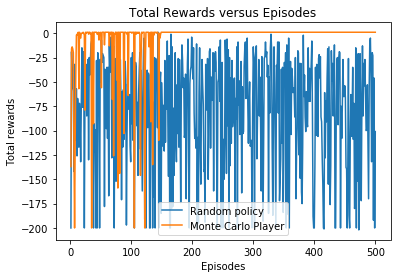

In [8]:
def playGridWorld(agent, xDim, yDim, numBlocks, transitProb, episodes=500, gamma = 0.8):
    """playGridWorld function:
                arguments: 
                agent: (object) the agent: Agent(random policy) or MonteCarloPlayer
                xDim, yDim: (int) height and width dimensions of the grid
                numBlocks: (int) number of blocked positions
                transitProb: (float) transition probability...between 0 and 1
                episodes: (int) number of episodes to play 
                gamma: (float) Discount factor for future rewards, between 0 and 1
    """
    agentName = "Random policy" if agent == Agent else "Monte Carlo Player"
    print("Playing with {}".format(agentName))
    totalRewards = []
    env = Environment(xDim, yDim, numBlocks, transitProb) #Create anvironment
    player = agent(env.grid) #Create the agent 
    for i in range(episodes):
        env.reset()
        stateActionValues = []
        env.reset()
        presentState = env.state
        totalReward = 0
        t = 0
        while not presentState.isTerminal(): #Play until terminal state (Goal or Fire)
            t+= 1
            action = player.getAction(presentState, i) #Agent takes action based on the present state
            print("Action selected: {}".format(action))
            nextState = env.nextStep(action) #Environment returns the next state based on the action
            print("Reward: {}".format(nextState.reward))
            reward = nextState.reward #Reward is returned based on the next state  
            totalReward +=reward
            if agent == MonteCarloPlayer:
                stateActionValues.append([presentState.loc, action, 0 , t]) #Append this experience gained 
            #to memory. this serves as the training set for the MonteCarloAgent
                for stateActionValue in stateActionValues:
                    stateActionValue[2] += gamma**(t- stateActionValue[3])*reward #Update the discounted action 
                #value for every past state encountered 
                #print(stateActionValue)
            presentState = nextState #Update the state
            if t == 200: #End game if there is no terminal state in 200 moves
                break
        if env.goalAchieved():
            print("You got to the goal!")
        else:
            print("You lost")
        totalRewards.append(totalReward)
        print("Total score: {}".format(totalReward))
        print("Game over")
        player.learn(stateActionValues)
    plt.plot(range(1, episodes+1), totalRewards, label = agentName)
    plt.xlabel("Episodes")
    plt.ylabel("Total rewards")
    plt.title("Total Rewards versus Episodes")
    
#randomPolicy = Agent()
#player = MonteCarloPlayer(grid)
playGridWorld(Agent, 6,6,2,1)
playGridWorld(MonteCarloPlayer, 6,6,2,1)
plt.legend()

Playing with Q Learning Agent
Grid world created
Goal Location set as [5,0]
Fire Location set as [5,5]
Block number 1 created at [5,2]
Block number 2 created at [0,4]
Block number 3 created at [1,1]
Episode 0
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
timestep 1
1.0
Exploring
Action selected: 3
remained in place
New position: (0, 0)
Reward: -1
-0.33130648789355743
timestep 2
1.0
Exploring
Action selected: 4
Moved right 
New position: (0, 1)
Reward: -1
-0.19717462701100053
timestep 3
1.0
Exploring
Action selected: 4
Moved right 
New position: (0, 2)
Reward: -1
-0.1916474805296723
timestep 4
1.0
Exploring
Action selected: 4
Moved right 
New position: (0, 3)
Reward: -1
-0.10609074700382726
timestep 5
1.0
Exploring
Action selected: 4
oops, you hit an obstacle
remained in place
New position: (0, 3)
Reward: -1
-0.10609074700382726
timestep 6
1.0
Exploring
Action selected: 3
Moved left
New position: (0, 2)
Reward: -1
-0.1916474805296723
timestep 7
1.0
Exploring
Action

Exploring
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 40
0.69049
Exploring
Action selected: 1
Moved up
New position: (4, 3)
Reward: -1
-0.5575757060117226
timestep 41
0.69049
Exploiting
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 42
0.69049
Exploring
Action selected: 1
Moved up
New position: (4, 3)
Reward: -1
-0.6537841934577957
timestep 43
0.69049
Exploring
Action selected: 2
Moved down
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 44
0.69049
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 45
0.69049
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 46
0.69049
Exploring
Action selected: 2
bottom
remained in place
New position: (5, 3)
Reward: -1
-0.5774006449693939
timestep 47
0.69049
Exploring
Action selected: 4
Moved right 
New posi

Exploring
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 11
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 12
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 13
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 14
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 15
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 16
0.28530201888518414
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
1.6829273983768394
timestep 17
0.28530201888518414
Exploiting
Action selected: 2
botto

-1.055205588664855
timestep 2
0.11642320326826068
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.19991180453774926
timestep 3
0.11642320326826068
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.0657003071888895
timestep 4
0.11642320326826068
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
4.0345464472150105
timestep 5
0.11642320326826068
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
5.869102980052342
You got to the goal!
Total score: 1
Game over
Episode 39
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
timestep 1
0.11478088294143461
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
-1.055205588664855
timestep 2
0.11478088294143461
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
0.2658336517309743
timestep 3
0.11478088294143461
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.1222394567193

remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 19
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 20
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 21
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 22
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 23
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 24
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.387328290251482
timestep 25
0.10050752878605643
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Re

New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 66
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 67
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 68
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 69
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 70
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 71
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.9008365404280974
timestep 72
0.10014334111979668
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
2.

0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 64
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 65
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 66
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 67
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 68
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 69
0.10002151473309895
Exploiting
Action selected: 2
bottom
remained in place
New position: (5, 1)
Reward: -1
3.275184054806849
timestep 70
0.10002151473309895
Exploiting
Action sel

timestep 3
0.10000048469250336
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.8537914897148298
timestep 4
0.10000048469250336
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
4.282175703517027
timestep 5
0.10000048469250336
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
5.869102980052342
You got to the goal!
Total score: 1
Game over
Episode 138
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
timestep 1
0.10000043622325303
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.4081111910224302
timestep 2
0.10000043622325303
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.5676458753252724
timestep 3
0.10000043622325303
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.8538081540598794
timestep 4
0.10000043622325303
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
4.282177401370035
timestep 5
0.1000

Reward: -1
0.4116535617145869
timestep 2
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.568564010014668
timestep 3
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.8539718956609064
timestep 4
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
4.282192584820967
timestep 5
0
Exploiting
Action selected: 2
Moved down
New position: (5, 0)
Reward: 5
5.869102980052342
You got to the goal!
Total score: 1
Game over
Episode 187
Grid world reset
Position: (0, 0)
Grid world reset
Position: (0, 0)
timestep 1
0
Exploiting
Action selected: 2
Moved down
New position: (1, 0)
Reward: -1
0.4116589664444483
timestep 2
0
Exploiting
Action selected: 2
Moved down
New position: (2, 0)
Reward: -1
1.568565079622683
timestep 3
0
Exploiting
Action selected: 2
Moved down
New position: (3, 0)
Reward: -1
2.853972038728703
timestep 4
0
Exploiting
Action selected: 2
Moved down
New position: (4, 0)
Reward: -1
4.282192594543581
timestep 5


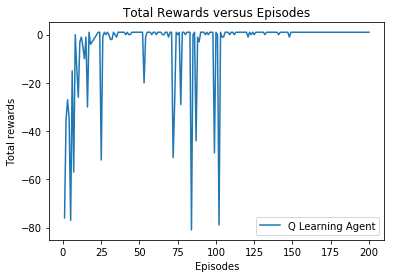

In [11]:
def playGridWorld(agent, xDim, yDim, numBlocks, transitProb, episodes=200, gamma = 0.5):
    """playGridWorld function:
                arguments: 
                agent: (object) the agent: Agent(random policy) or MonteCarloPlayer
                xDim, yDim: (int) height and width dimensions of the grid
                numBlocks: (int) number of blocked positions
                transitProb: (float) transition probability...between 0 and 1
                episodes: (int) number of episodes to play 
                gamma: (float) Discount factor for future rewards, between 0 and 1
    """
    
    if agent == Agent:
        agentName = "Random policy" 
    elif agent == MonteCarloPlayer:
        agentName = "Monte Carlo Player"
    else:
        agentName = "Q Learning Agent"
    
    print("Playing with {}".format(agentName))
    totalRewards = []
    env = Environment(xDim, yDim, numBlocks, transitProb) #Create anvironment
    player = agent(env.grid) #Create the agent 
    for i in range(episodes):
        print("Episode {}".format(i))
        env.reset()
        stateActionValues = []
        env.reset()
        presentState = env.state
        totalReward = 0
        t = 0
        while not presentState.isTerminal(): #Play until terminal state (Goal or Fire)
            t+= 1
            print("timestep {}".format(t))
            action = player.getAction(presentState, i) #Agent takes action based on the present state
            print("Action selected: {}".format(action))
            nextState = env.nextStep(action) #Environment returns the next state based on the action
            print("Reward: {}".format(nextState.reward))
            reward = nextState.reward #Reward is returned based on the next state  
            totalReward +=reward
            if agent  == QLearningPlayer:
                stateActionValue = [presentState.loc, action, reward , nextState.loc] #Experience tuple
                #For the observed state Action Pair
                player.learn(stateActionValue) #Learn after every step based on temporal difference 
            else:
                #print("hello")
                stateActionValues.append([presentState.loc, action, 0 , t]) 
                #Append this experience gained 
            #to memory. this serves as the training set for the agent
                for stateActionValue in stateActionValues:
                    stateActionValue[2] += gamma**(t- stateActionValue[3])*reward #Update the discounted action 
                    #value for every past state encountered 
                    #print(stateActionValue)
            presentState = nextState #Update the state
            if t == 200: #End game if there is no terminal state in 200 moves
                break
        if env.goalAchieved():
            print("You got to the goal!")
        else:
            print("You lost")
        totalRewards.append(totalReward)
        print("Total score: {}".format(totalReward))
        print("Game over")
        if agent ==  MonteCarloPlayer:
            #print("hello")
            #print(learning)
            player.learn(stateActionValues)
    plt.plot(range(1, episodes+1), totalRewards, label = agentName)
    plt.xlabel("Episodes")
    plt.ylabel("Total rewards")
    plt.title("Total Rewards versus Episodes")

playGridWorld(QLearningPlayer, 6,6,3,1)
plt.legend()